# Lab 3: Decision tree - Wine quality

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

## 1. Chuẩn bị dữ liệu

Features shape: (6497, 11)
Targets shape: (6497, 1)
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9

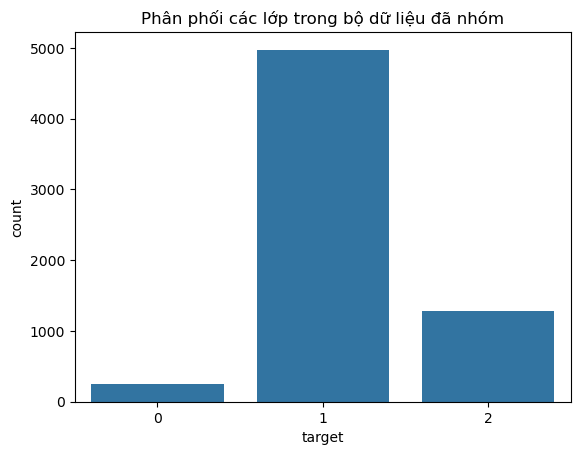


Tỷ lệ 40.0/60.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
target
1    0.765589
2    0.196690
0    0.037721
Name: proportion, dtype: float64
Phân phối lớp trong tập kiểm tra:
target
1    0.765581
2    0.196461
0    0.037958
Name: proportion, dtype: float64


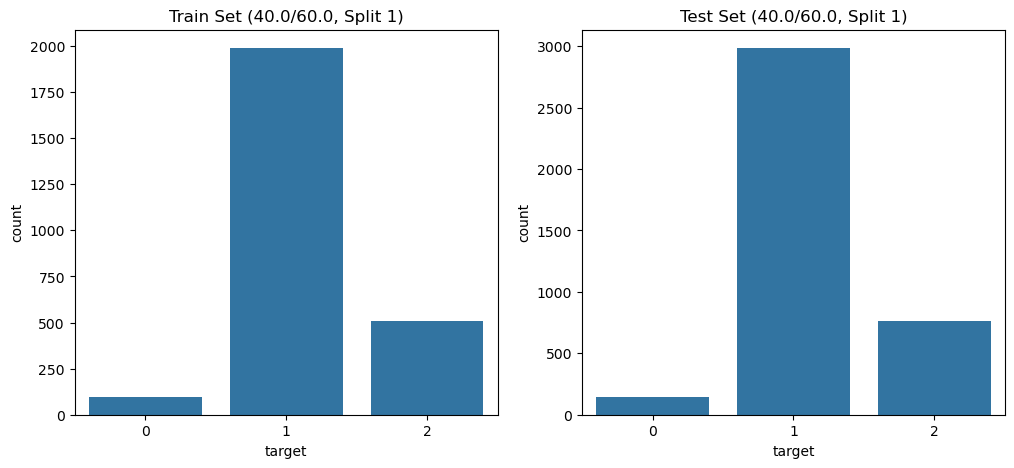


Tỷ lệ 60.0/40.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
target
1    0.765521
2    0.196511
0    0.037968
Name: proportion, dtype: float64
Phân phối lớp trong tập kiểm tra:
target
1    0.765679
2    0.196614
0    0.037707
Name: proportion, dtype: float64


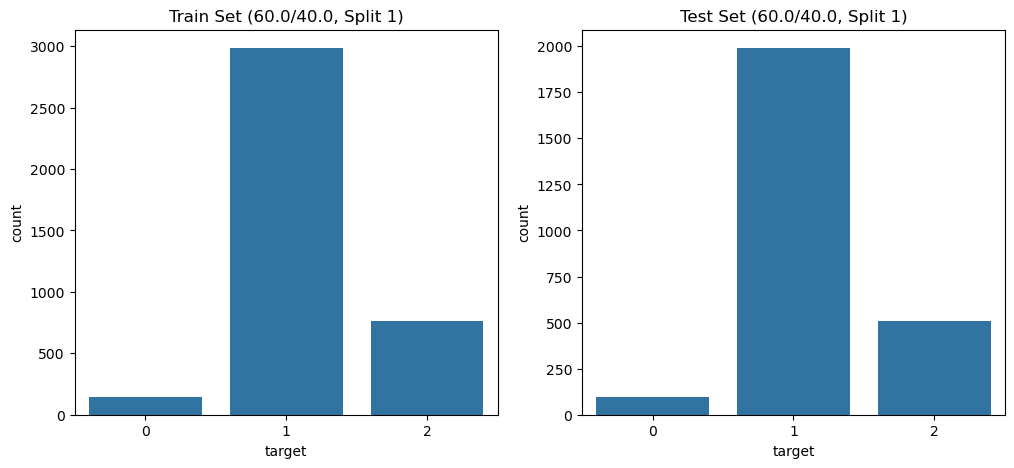


Tỷ lệ 80.0/20.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
target
1    0.765634
2    0.196459
0    0.037906
Name: proportion, dtype: float64
Phân phối lớp trong tập kiểm tra:
target
1    0.765385
2    0.196923
0    0.037692
Name: proportion, dtype: float64


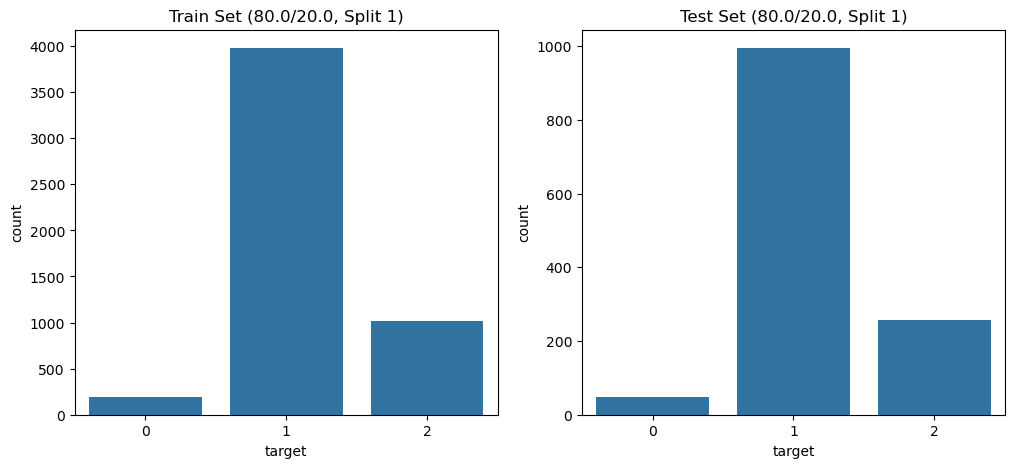


Tỷ lệ 90.0/10.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
target
1    0.765521
2    0.196511
0    0.037968
Name: proportion, dtype: float64
Phân phối lớp trong tập kiểm tra:
target
1    0.766154
2    0.196923
0    0.036923
Name: proportion, dtype: float64


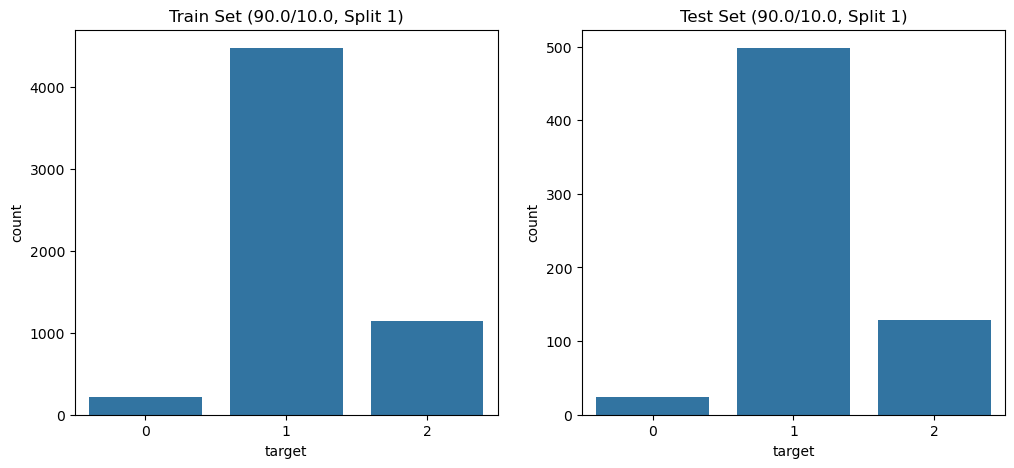

In [30]:
wine_quality = fetch_ucirepo(id=186) 

X = wine_quality.data.features
y = wine_quality.data.targets
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

# Chuyển đổi y từ DataFrame thành numpy ndarray và làm phẳng mảng y thành mảng 1 chiều
y = y.values.flatten() 

df = pd.DataFrame(X)
print(df.head())

def map_quality_class(target):
    if target <= 4:
        return 0  # Low quality
    elif target <= 6:
        return 1  # Standard quality
    else:
        return 2  # High quality

df['target'] = pd.Series(y).apply(map_quality_class)


sns.countplot(x='target', data=df)
plt.title("Phân phối các lớp trong bộ dữ liệu đã nhóm")
plt.show()

# Phân chia dữ liệu
X = df.drop(['target'], axis=1)
y = df['target']
proportions = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
splits = {}

for train_size, test_size in proportions:
    for i in range(1):  
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=i)
        for train_idx, test_idx in sss.split(X, y):
            splits[(train_size, test_size, i)] = (
                X.iloc[train_idx],
                X.iloc[test_idx],
                y.iloc[train_idx],
                y.iloc[test_idx]
            )
for (train_size, test_size, i), (X_train, X_test, y_train, y_test) in splits.items():
    print(f"\nTỷ lệ {train_size*100}/{test_size*100}, Lần chia thứ {i+1}:")
    print(f"Phân phối lớp trong tập huấn luyện:")
    print(y_train.value_counts(normalize=True))
    print(f"Phân phối lớp trong tập kiểm tra:")
    print(y_test.value_counts(normalize=True))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(x=y_train, ax=ax[0])
    ax[0].set_title(f"Train Set ({train_size*100}/{test_size*100}, Split {i+1})")
    sns.countplot(x=y_test, ax=ax[1])
    ax[1].set_title(f"Test Set ({train_size*100}/{test_size*100}, Split {i+1})")
    plt.show()

## 2. Triển khai Decision Tree

In [6]:
results = {}
for (train_size, test_size, i), (X_train, X_test, y_train, y_test) in splits.items():
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    results[(train_size, test_size, i)] = {
        "model": clf,
        "y_pred": y_pred,
        "y_test": y_test,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    
    # Xuất cây quyết định ra tệp .dot
    file_name = f"decision_tree_{int(train_size*100)}_{int(test_size*100)}_split_{i+1}.dot"
    with open(file_name, "w") as f:
        export_graphviz(
            clf,
            out_file=f,
            feature_names=X.columns,
            class_names=["Low quality", "Standard quality", "High quality"],
            filled=True
        )
    print(f"Cây quyết định đã được lưu vào {file_name}")

Cây quyết định đã được lưu vào decision_tree_40_60_split_1.dot
Cây quyết định đã được lưu vào decision_tree_60_40_split_1.dot
Cây quyết định đã được lưu vào decision_tree_80_20_split_1.dot
Cây quyết định đã được lưu vào decision_tree_90_10_split_1.dot


- Xảy ra một số vấn đề khi Graphviz được cài đặt vào môi trường nên em đã dùng phương pháp thay thế: Trực tiếp xuất cây quyết định ra tệp .dot và sử dụng công cụ trực quan hóa bên ngoài. 
- Sau khi chạy chương trình, sẽ nhận được các tệp .dot như: decision_tree_40_60_split_1.dot
- Để chuyển đổi tệp .dot sang định dạng hình ảnh (PNG), cần sử dụng lệnh dot trong terminal: dot -Tpng decision_tree_40_60_split_1.dot -o decision_tree_40_60_split_1.png
- Khi sử dụng phương pháp này: có thể sử dụng Graphviz độc lập trên terminal để xử lý và trực quan hóa tệp .dot, dễ dàng lưu trữ và chia sẻ tệp .dot

## 3. Đánh giá hiệu suất của Decision Tree


Train/Test Split: 40/60, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.22      0.20      0.21       148
Standard quality       0.85      0.84      0.85      2985
    High quality       0.52      0.53      0.52       766

        accuracy                           0.76      3899
       macro avg       0.53      0.52      0.53      3899
    weighted avg       0.76      0.76      0.76      3899



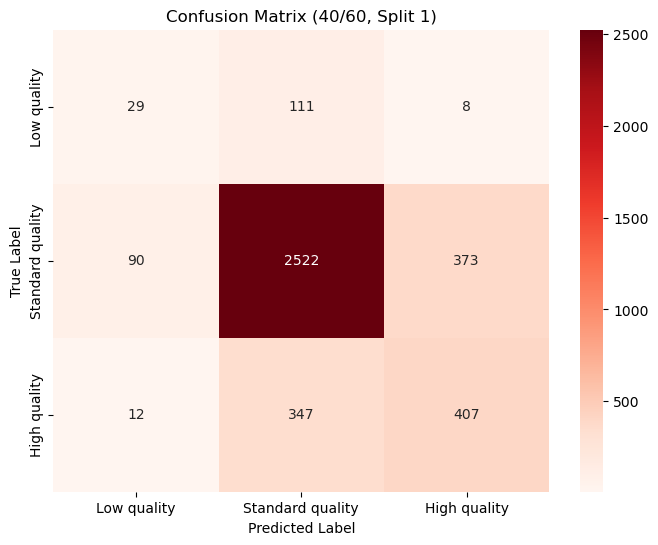


Train/Test Split: 60/40, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.24      0.30      0.27        98
Standard quality       0.86      0.85      0.86      1990
    High quality       0.57      0.58      0.57       511

        accuracy                           0.78      2599
       macro avg       0.56      0.57      0.57      2599
    weighted avg       0.78      0.78      0.78      2599



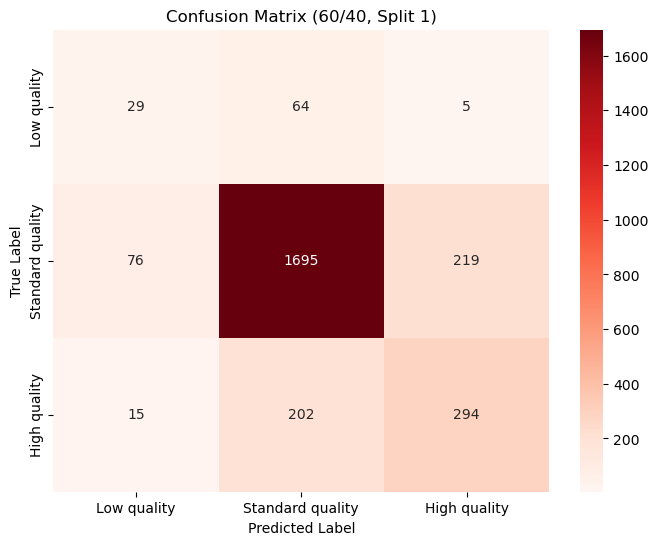


Train/Test Split: 80/20, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.23      0.24      0.24        49
Standard quality       0.86      0.85      0.86       995
    High quality       0.57      0.60      0.59       256

        accuracy                           0.78      1300
       macro avg       0.56      0.56      0.56      1300
    weighted avg       0.78      0.78      0.78      1300



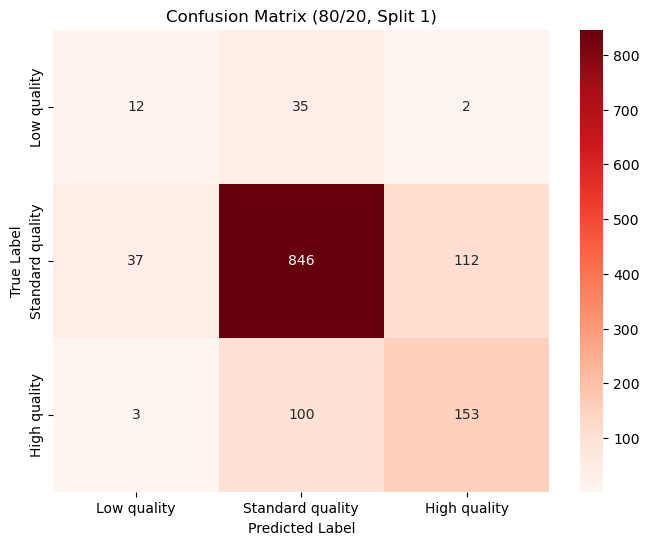


Train/Test Split: 90/10, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.17      0.21      0.19        24
Standard quality       0.87      0.88      0.87       498
    High quality       0.63      0.57      0.60       128

        accuracy                           0.79       650
       macro avg       0.56      0.55      0.55       650
    weighted avg       0.79      0.79      0.79       650



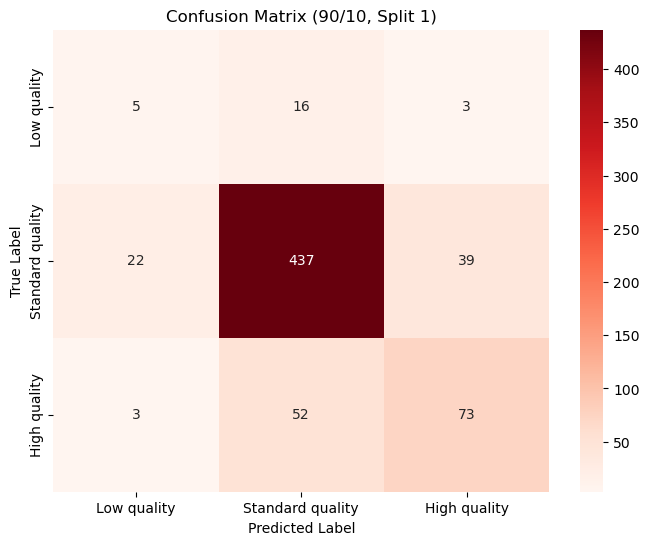

In [26]:
for (train_size, test_size, i), result in results.items():
    clf = result["model"]
    y_test = result["y_test"]
    y_pred = result["y_pred"]
    report = classification_report(y_test, y_pred, target_names=["Low quality", "Standard quality", "High quality"])
    cm = confusion_matrix(y_test, y_pred)    
    print(f"\nTrain/Test Split: {int(train_size*100)}/{int(test_size*100)}, Lần chia thứ {i+1}")
    print("Classification Report:")
    print(report)
    
    # Vẽ ma trận 
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["Low quality", "Standard quality", "High quality"], yticklabels=["Low quality", "Standard quality", "High quality"])
    plt.title(f"Confusion Matrix ({int(train_size*100)}/{int(test_size*100)}, Split {i+1})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

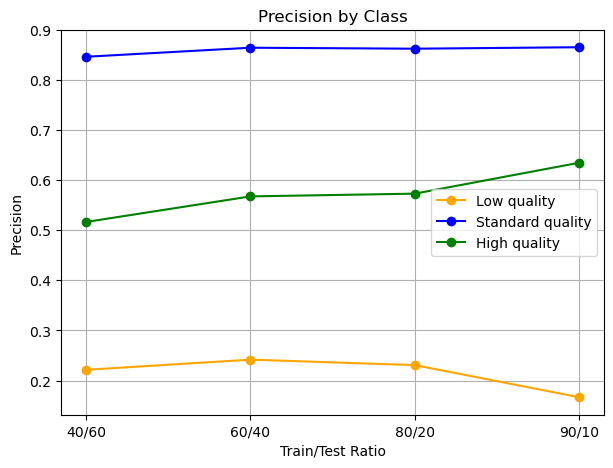

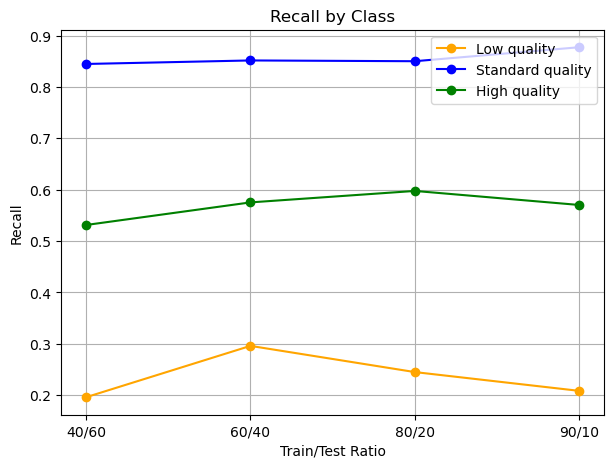

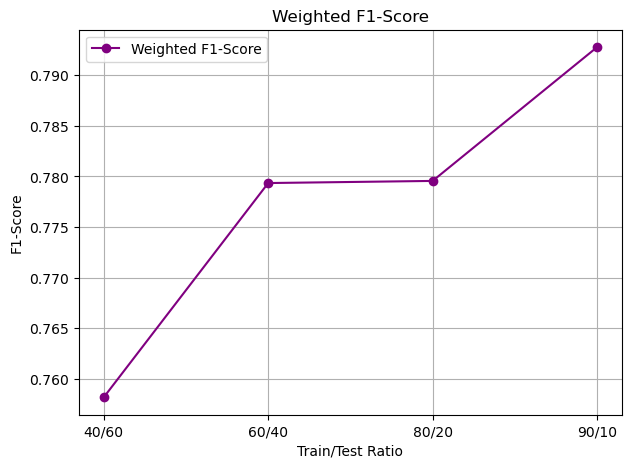

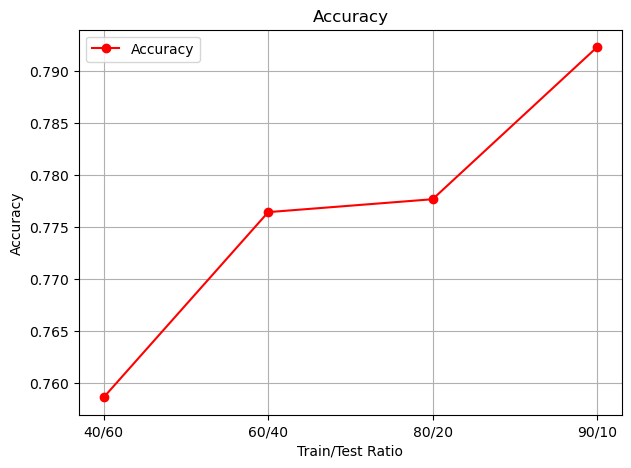

Final Metrics Summary:
Train/Test Ratio: 40/60
  Precision: Low=0.2214, Standard=0.8463, High=0.5165
  Recall: Low=0.1959, Standard=0.8449, High=0.5313
  Weighted F1-Score: 0.7582
  Accuracy: 0.7587

Train/Test Ratio: 60/40
  Precision: Low=0.2417, Standard=0.8644, High=0.5676
  Recall: Low=0.2959, Standard=0.8518, High=0.5753
  Weighted F1-Score: 0.7793
  Accuracy: 0.7765

Train/Test Ratio: 80/20
  Precision: Low=0.2308, Standard=0.8624, High=0.5730
  Recall: Low=0.2449, Standard=0.8503, High=0.5977
  Weighted F1-Score: 0.7796
  Accuracy: 0.7777

Train/Test Ratio: 90/10
  Precision: Low=0.1667, Standard=0.8653, High=0.6348
  Recall: Low=0.2083, Standard=0.8775, High=0.5703
  Weighted F1-Score: 0.7928
  Accuracy: 0.7923



In [10]:
# Vẽ các biểu đồ Precision, Recall, F1-Score, Accuracy
def plot_metrics_line(results):
    train_test_ratios = []
    precision_class0 = []  # Low quality
    precision_class1 = []  # Standard quality
    precision_class2 = []  # High quality
    recall_class0 = []
    recall_class1 = []
    recall_class2 = []
    weighted_f1_scores = []
    accuracies = []

    for (train_size, test_size, i), result in results.items():
        clf = result["model"]
        y_test = result["y_test"]
        y_pred = result["y_pred"]

        report = classification_report(y_test, y_pred, target_names=["Low quality", "Standard quality", "High quality"], output_dict=True)
        train_test_ratios.append(f"{int(train_size * 100)}/{int(test_size * 100)}")

        precision_class0.append(report["Low quality"]["precision"])
        precision_class1.append(report["Standard quality"]["precision"])
        precision_class2.append(report["High quality"]["precision"])

        recall_class0.append(report["Low quality"]["recall"])
        recall_class1.append(report["Standard quality"]["recall"])
        recall_class2.append(report["High quality"]["recall"])

        weighted_f1_scores.append(report["weighted avg"]["f1-score"])
        accuracies.append(accuracy_score(y_test, y_pred))

    # Vẽ biểu đồ Precision 
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, precision_class0, marker='o', linestyle='-', color='orange', label='Low quality')
    plt.plot(train_test_ratios, precision_class1, marker='o', linestyle='-', color='blue', label='Standard quality')
    plt.plot(train_test_ratios, precision_class2, marker='o', linestyle='-', color='green', label='High quality')
    plt.title("Precision by Class")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Recall 
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, recall_class0, marker='o', linestyle='-', color='orange', label='Low quality')
    plt.plot(train_test_ratios, recall_class1, marker='o', linestyle='-', color='blue', label='Standard quality')
    plt.plot(train_test_ratios, recall_class2, marker='o', linestyle='-', color='green', label='High quality')
    plt.title("Recall by Class")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Weighted F1-Score
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, weighted_f1_scores, marker='o', linestyle='-', color='purple', label='Weighted F1-Score')
    plt.title("Weighted F1-Score")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, accuracies, marker='o', linestyle='-', color='red', label='Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Final Metrics Summary:")
    for ratio, precision0, precision1, precision2, recall0, recall1, recall2, f1, acc in zip(
        train_test_ratios, precision_class0, precision_class1, precision_class2, recall_class0, recall_class1, recall_class2, weighted_f1_scores, accuracies
    ):
        print(f"Train/Test Ratio: {ratio}")
        print(f"  Precision: Low={precision0:.4f}, Standard={precision1:.4f}, High={precision2:.4f}")
        print(f"  Recall: Low={recall0:.4f}, Standard={recall1:.4f}, High={recall2:.4f}")
        print(f"  Weighted F1-Score: {f1:.4f}")
        print(f"  Accuracy: {acc:.4f}\n")
plot_metrics_line(results)

## 4. Độ sâu và độ chính xác của Decision Tree

In [12]:
# Chia dữ liệu thành train/test với tỷ lệ 80/20
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

for max_depth in max_depth_values:
    # Kiểm tra nếu max_depth là None, thì không giới hạn độ sâu
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)  
    accuracy_results.append(accuracy)
    
    # Xuất cây quyết định ra tệp .dot
    if max_depth is None:
        file_name = f"decision_tree_max_depth_None.dot"
    else:
        file_name = f"decision_tree_max_depth_{max_depth}.dot"
    
    with open(file_name, "w") as f:
        export_graphviz(
            clf,
            out_file=f,
            feature_names=X.columns,
            class_names=["Low quality", "Standard quality", "High quality"],
            filled=True
        )
    print(f"Cây quyết định với max_depth={max_depth} đã được lưu vào {file_name}")

Cây quyết định với max_depth=None đã được lưu vào decision_tree_max_depth_None.dot
Cây quyết định với max_depth=2 đã được lưu vào decision_tree_max_depth_2.dot
Cây quyết định với max_depth=3 đã được lưu vào decision_tree_max_depth_3.dot
Cây quyết định với max_depth=4 đã được lưu vào decision_tree_max_depth_4.dot
Cây quyết định với max_depth=5 đã được lưu vào decision_tree_max_depth_5.dot
Cây quyết định với max_depth=6 đã được lưu vào decision_tree_max_depth_6.dot
Cây quyết định với max_depth=7 đã được lưu vào decision_tree_max_depth_7.dot


- Để chuyển đổi tệp .dot sang định dạng hình ảnh (PNG), cần sử dụng lệnh dot trong terminal: dot -Tpng decision_tree_max_depth_7.dot -o decision_tree_max_depth_7.png

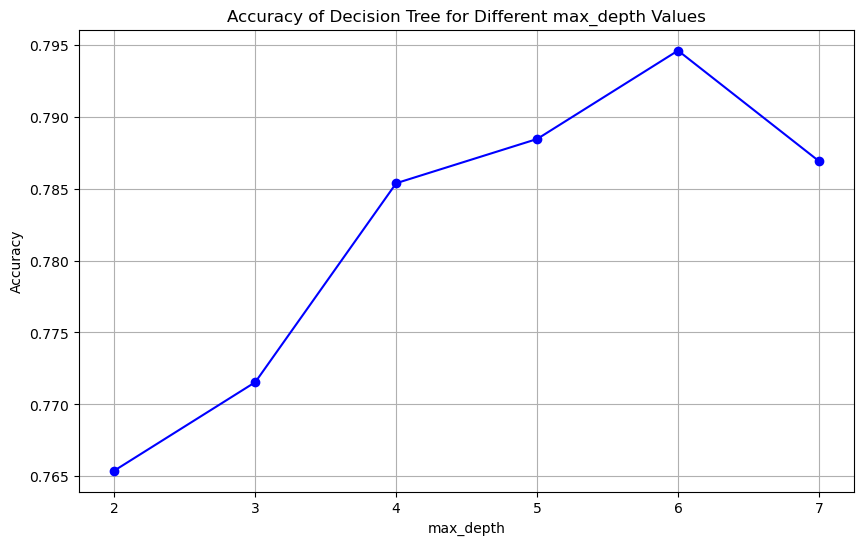


Độ chính xác của các mô hình Decision Tree với các giá trị max_depth:
max_depth=2: Accuracy=0.7654
max_depth=3: Accuracy=0.7715
max_depth=4: Accuracy=0.7854
max_depth=5: Accuracy=0.7885
max_depth=6: Accuracy=0.7946
max_depth=7: Accuracy=0.7869


In [14]:
# Loại bỏ None để vẽ biểu đồ
max_depth_values_no_none = [x for x in max_depth_values if x is not None]
accuracy_results_no_none = [accuracy_results[i] for i, val in enumerate(max_depth_values) if val is not None]

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values_no_none, accuracy_results_no_none, marker='o', linestyle='-', color='b')
plt.title("Accuracy of Decision Tree for Different max_depth Values")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xticks(max_depth_values_no_none)  # Sử dụng các giá trị max_depth không phải None
plt.grid(True)
plt.show()
print("\nĐộ chính xác của các mô hình Decision Tree với các giá trị max_depth:")
for max_depth, accuracy in zip(max_depth_values_no_none, accuracy_results_no_none):
    print(f"max_depth={max_depth}: Accuracy={accuracy:.4f}")